 ## Setting up a network model and starting a first training

In this and the following exercise, we are going to practise, how to set up a neural network model and perform a first training with this network.
We will use the DermaMNIST from the MedMNIST datasets, which you have seen last lecture.

In [1]:
# Imports
import os
import sys
# from tqdm import trange
# from tqdm import tqdm
# from skimage.util import montage
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision as torchvision

!pip install medmnist
import medmnist
from medmnist.dataset import PathMNIST, ChestMNIST, DermaMNIST, OCTMNIST, PneumoniaMNIST, RetinaMNIST, BreastMNIST, OrganMNISTAxial, OrganMNISTCoronal, OrganMNISTSagittal
from medmnist.evaluator import getAUC, getACC
from medmnist.info import INFO

In [2]:
print("Version:", medmnist.__version__)

Version: 2.0.2


In [3]:
# various MedMNIST datasets
data_flag = 'dermamnist'
download = True
input_root = 'tmp_data/'
!mkdir 'tmp_data'

flag_to_class = {
    "pathmnist": PathMNIST,
    "chestmnist": ChestMNIST,
    "dermamnist": DermaMNIST,
    "octmnist": OCTMNIST,
    "pneumoniamnist": PneumoniaMNIST,
    "retinamnist": RetinaMNIST,
    "breastmnist": BreastMNIST,
    "organmnist_axial": OrganMNISTAxial,
    "organmnist_coronal": OrganMNISTCoronal,
    "organmnist_sagittal": OrganMNISTSagittal,
}

DataClass = flag_to_class[data_flag]

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
label_dict = info['label']

print(f"Info:\n{info}\n")
print(f"Task:\n{task}\n")
print(f"Channels:\n{n_channels}\n")
print(f"Number of classes:\n{n_classes}\n")
print(f"Label:\n{label_dict}\n")

Info:
{'python_class': 'DermaMNIST', 'description': 'The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.', 'url': 'https://zenodo.org/record/5208230/files/dermamnist.npz?download=1', 'MD5': '0744692d530f8e62ec473284d019b0c7', 'task': 'multi-class', 'label': {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}, 'n_channels': 3, 'n_samples': {'train': 7007, 'val': 1003, 'test': 2005}, 'license': 'CC BY-NC 4.0'}

Task:
multi-class

Channels:
3

Number of classes:
7

Label:
{'0': 'a

## Defining the augmentations

As described in the last exercise, we now define the augmentations:

In [4]:
# Imagenet values
norm_mean = (0.4914)
norm_std = (0.2023)

# define the transformaitons the images go through each time it is used for training
# includes augmentation AND normalization as described above
augmentation_train = transforms.Compose([
                                  # resize image to the network input size
                                  transforms.Resize((28,28)),
                                  # rotate the image with a certain angle range, randomly chosen
                                  transforms.RandomRotation(degrees=20),
                                  # convert the image into a tensor so it can be processed by the GPU
                                  transforms.ToTensor(),
                                  # normalize the image with the mean and std of ImageNet
                                  transforms.Normalize(norm_mean, norm_std),
                                   ])

# no augmentation for the test data only resizing, conversion to tensor and normalization
augmentation_test = transforms.Compose([
                    transforms.Resize((28,28)),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

## Splitting up data

Set up datasets for training, validation and testing

In [5]:
# load the data
train_dataset = DataClass(root=input_root, split='train', transform=augmentation_train, download=download)
test_dataset = DataClass(root=input_root, split='test', transform=augmentation_test, download=download)
val_dataset = DataClass(root=input_root, split='val', transform=augmentation_test, download=download)

19725312it [00:16, 1169703.20it/s]                              


Using downloaded and verified file: tmp_data/dermamnist.npz
Using downloaded and verified file: tmp_data/dermamnist.npz


In [6]:
# Some detailed information about all splits
print("===================")
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset DermaMNIST (dermamnist)
    Number of datapoints: 7007
    Root location: tmp_data/
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0
Dataset DermaMNIST (dermamnist)
    Number of datapoints: 1003
    Root location: tmp_dat

## Create Dataloaders

PyTorch provides template Dataloader classes for easy data handling, assigning according transforms and splits. You can find more information about how PyTorch handles datasets and data loading [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [7]:
BATCH_SIZE = 128
### encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
### the next() function returns the next item from the iterator.
batch_images, batch_labels = next(iter(train_loader))

torch.Size([3, 28, 28])


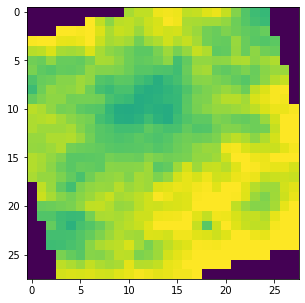

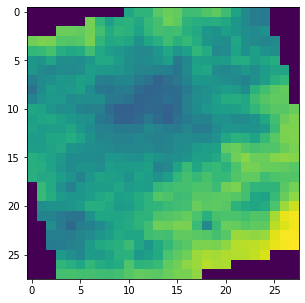

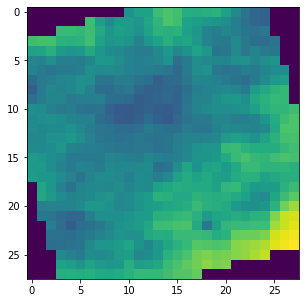

In [9]:
# show all 3 channels of image 10
print(batch_images[0].shape)

fig = plt.figure(figsize=(5, 5))
plt.imshow(batch_images[11][0,:,:])
fig = plt.figure(figsize=(5, 5))
plt.imshow(batch_images[11][1,:,:])
fig = plt.figure(figsize=(5, 5))
plt.imshow(batch_images[11][2,:,:])

### different color maps
### cmap='bone', cmap = 'summer', cmap = 'seismic'

## Define a Convolutional Neural Network

Pytorch makes it very easy to define a neural network. We have layers like Convolutions, ReLU non-linearity, Maxpooling etc. directly from [torch library](https://pytorch.org/docs/stable/nn.html).

In this tutorial, we use The LeNet architecture introduced by LeCun et al. in their 1998 paper, [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). As the name of the paper suggests, the authors’ implementation of LeNet was used primarily for OCR and character recognition in documents. The LeNet architecture is straightforward and small, (in terms of memory footprint), making it perfect for teaching the basics of CNNs.

To define a neural network in PyTorch one has to create a class inhereting from [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). Crucially, this class has to include the function forward() which defines which computation should be performed at every call given a batch of inputs.

In [10]:
from torch import nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 7
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5), padding=2)
        self.nonlin1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5)) 
        self.nonlin2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.nonlin3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.nonlin4 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)
        self.nonlin5 = nn.ReLU()

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.nonlin1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.nonlin2(x)
        x = self.pool2(x)
        
        x = x.view(-1, self.num_flat_features(x))

        x = self.fc1(x)
        x = self.nonlin3(x)
        x = self.fc2(x)
        x = self.nonlin4(x)
        x = self.fc3(x)
        x = self.nonlin5(x)

        return x

    def num_flat_features(self, x):
        
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


You can use torchsummary to print out the architecture of your model given a certain input.

In [11]:
from torchsummary import summary

model = LeNet()
model.to(device)

summary(model, input_size=(1,28,28), batch_size=127)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [127, 6, 28, 28]             156
              ReLU-2           [127, 6, 28, 28]               0
         MaxPool2d-3           [127, 6, 14, 14]               0
            Conv2d-4          [127, 16, 10, 10]           2,416
              ReLU-5          [127, 16, 10, 10]               0
         MaxPool2d-6            [127, 16, 5, 5]               0
            Linear-7                 [127, 120]          48,120
              ReLU-8                 [127, 120]               0
            Linear-9                  [127, 84]          10,164
             ReLU-10                  [127, 84]               0
           Linear-11                   [127, 7]             595
             ReLU-12                   [127, 7]               0
Total params: 61,451
Trainable params: 61,451
Non-trainable params: 0
---------------------------------

## Define a Loss function

Let's use a Classification Cross-Entropy loss.

$H_{y'} (y) := - \sum_{i} y_{i}' \log (y_i)$

### Median Frequency Balancing
There are datasets which have a large imbalance in the amount of label occurrence. A prediction would be therefore biased towards stronger represented classes. As a solution, we use **Median Frequency Balancing**. Essentially this tasks the optimizer to weight examples of rare cases more highly than examples of common cases that are processed more frequently.

In [12]:
# get the class labels of each image
class_labels = train_dataset.labels
# get the number of different classes
num_classes = np.max(class_labels)+1
# empty array for counting instance of each class
count_labels = np.zeros(num_classes)
# empty array for weights of each class
class_weights = np.zeros(num_classes)

# populate the count array
for l in class_labels:
    count_labels[l] += 1

# get median count
median_freq = np.median(count_labels)

# calculate the weigths
for i in range(num_classes):
    class_weights[i] = median_freq/count_labels[i]

# print the weights
for i in range(num_classes):
    print("class", i, ":", class_weights[i])

class 0 : 1.5745614035087718
class 1 : 1.0
class 2 : 0.4668400520156047
class 3 : 4.4875
class 4 : 0.46084724005134786
class 5 : 0.07649691029192414
class 6 : 3.6262626262626263


Now we define the loss function with the weights

In [13]:
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)

## Define the Optimizer

The most common and effective optimizer currently used is **Adam: Adaptive Moments**. You can check out [the paper on it](https://arxiv.org/abs/1412.6980) for more information.


In [14]:
import torch.optim as optim

# now lets go back to the initial LeNet architecture
net = LeNet()
net = net.to(device)

# and define an optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-5)
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (nonlin1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (nonlin2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (nonlin3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (nonlin4): ReLU()
  (fc3): Linear(in_features=84, out_features=7, bias=True)
  (nonlin5): ReLU()
)


## Network training

After everything has been set up, we can now start an actual training on our dataset. To save time, for the moment we will run only ten epochs. Within the training, our dataloader is used to load a batch from our dataset. This batch is forwarded to the model. The corresponding output is compared against its labels with the chosen loss function, here called 'criterion'. Then, the loss values are backpropagated through the whole model.

After, the training step a validation step is performed. Here the network is set to .eval() mode in which its weights are not being updated and consequently backprogagation is not needed.

In [15]:
num_epochs = 10

for epoch in range(num_epochs):

    ##### Training loop #####
    running_loss_train = 0.0
    num_correct_train = 0
    num_all_train = 0

    for i, data in enumerate(train_loader):

        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), torch.squeeze(labels).to(device)

        # set model to training mode
        net.train()

        # set the parameter gradients to zero
        optimizer.zero_grad()

        # calculate the network output and its loss 
        outputs = net(inputs[:,0:1,:,:])
        loss = criterion(outputs, labels)

        # During training we need to backpropagate the loss and conduct an optimization step 
        loss.backward()
        optimizer.step()

        # compute running loss and accuracy
        running_loss_train += loss.item()

        _, predicted = torch.max(outputs, 1)
        num_correct_train += torch.sum(predicted == labels).item()
        num_all_train += labels.size()[0]

        training_loss = running_loss_train / num_all_train
        training_accuracy = num_correct_train / num_all_train


    ##### Validation loop #####
    running_loss_val = 0.0
    num_correct_val = 0
    num_all_val = 0

    for i, data in enumerate(val_loader):

        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), torch.squeeze(labels).to(device)

        # set model to evaluation mode
        net.eval()

        # calculate the network output and its loss 
        outputs = net(inputs[:,0:1,:,:])
        loss = criterion(outputs, labels)

        # compute running loss and accuracy
        running_loss_val += loss

        _, predicted = torch.max(outputs, 1)
        num_correct_val += torch.sum(predicted == labels).item()
        num_all_val += labels.size()[0]

        validation_loss = running_loss_val / num_all_val
        validation_accuracy = num_correct_val / num_all_val

    print('Epoch: {}, training loss: {:.4f}, training accuracy: {}%, validation loss: {:.4f}, validation accuracy: {}%, '.format(epoch+1, training_loss, np.round(training_accuracy, 3) * 100, validation_loss, np.round(validation_accuracy, 3) * 100))


Epoch: 1, training loss: 0.0153, training accuracy: 2.8000000000000003%, validation loss: 0.0155, validation accuracy: 2.6%, 
Epoch: 2, training loss: 0.0153, training accuracy: 1.6%, validation loss: 0.0155, validation accuracy: 1.6%, 
Epoch: 3, training loss: 0.0153, training accuracy: 1.7000000000000002%, validation loss: 0.0155, validation accuracy: 1.7000000000000002%, 
Epoch: 4, training loss: 0.0152, training accuracy: 2.0%, validation loss: 0.0155, validation accuracy: 2.1%, 
Epoch: 5, training loss: 0.0152, training accuracy: 3.0%, validation loss: 0.0155, validation accuracy: 3.0%, 
Epoch: 6, training loss: 0.0152, training accuracy: 4.0%, validation loss: 0.0155, validation accuracy: 3.5999999999999996%, 
Epoch: 7, training loss: 0.0152, training accuracy: 5.4%, validation loss: 0.0155, validation accuracy: 4.9%, 
Epoch: 8, training loss: 0.0152, training accuracy: 6.7%, validation loss: 0.0155, validation accuracy: 5.6000000000000005%, 
Epoch: 9, training loss: 0.0152, trai

## Homework
After performing the training and validation of your system you are now ready to perform the inference on your test set. Implement the inference step for out dataset. Hint: It will look very similar to one the previous loops (train or validation).

In [16]:
running_loss_test = 0.0
num_correct_test = 0
num_all_test = 0

for i, data in enumerate(test_loader):

    ########## Implement the data loading and prediction on the test set ##########

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    print(type(labels))
    net.eval()  # Set model to validation mode

    # -------------------------------
    # Calculate the network output and its loss
    outputs = net(inputs[:,0:1,:,:])
    loss = criterion(outputs, torch.argmax(labels, 1))

    ########## ------------------------------- ##########
    
    _, predicted = torch.max(outputs, 1)
    num_correct_test += torch.sum(predicted == labels).item()
    num_all_test += labels.size()[0]
    running_loss_test += loss.item()

    test_loss = running_loss_test / num_all_test
    test_accuracy = num_correct_test / num_all_test

print('Loss for test set is {}'.format(test_loss))
print('Test accuracy of the network: {}%'.format(np.round(test_accuracy, 3)*100))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Loss for test set is 0.01585624872003113
Test accuracy of the network: 639.6%
